In [1]:
from utils import * 
from algorithms import *
from agents import *

# parameters
disclosure = ['step']; numStates = 6; depth = 1
#disclosure = ['step', 'currentBid', 'currentAsk', 'buy', 'sell', 'price', 'sale']; numStates = 12; depth = 1;
#disclosure = ['step', 'currentBid', 'currentAsk', 'buy', 'sell', 'price', 'sale', 'currentBidIdx_0', 'currentBidIdx_1','currentBidIdx_2','currentBidIdx_3','currentAskIdx_0', 'currentAskIdx_1', 'currentAskIdx_2','currentAskIdx_3']; numStates = 20; depth = 1; 
#depth = 1; numStates = 28; disclosure = ['step', 'currentBid', 'currentAsk', 'buy', 'sell', 'price', 'sale','currentBidIdx_0', 'currentBidIdx_1', 'currentBidIdx_2', 'currentBidIdx_3','currentAskIdx_0', 'currentAskIdx_1', 'currentAskIdx_2', 'currentAskIdx_3','bids_0', 'bids_1', 'bids_2', 'bids_3', 'asks_0', 'asks_1', 'asks_2', 'asks_3']

# game setup
numRounds, numPeriods, numSteps, numBuyers, numSellers, numTokens, gameTypes, seed = 10000, 1, 16, 4, 4, 4, '1111', None
gameData = [gameTypes, numBuyers, numSellers, numTokens, numRounds, numPeriods, numSteps, seed]
episodeLength = 16; numTrajectories = 10; gamma=0.99; std_init = 0.7; std_decay = 0.995; std_min = 0.05; lr = 0.0003; k = -0.15; p = 0.3
buyers = [
    Reinforcer(gameData, disclosure, index=0, buyer=1, reinforcer=1, verbose =0, numStates = numStates, algo='VPGContinuous',algoArgs = [numStates, episodeLength, numTrajectories, gamma, std_init, std_decay, std_min, lr, k, p]),
           ZeroIntelligence(gameData, disclosure, index=0, buyer=1, reinforcer=0),
           ZeroIntelligence(gameData, disclosure, index=0, buyer=1, reinforcer=0),
           ZeroIntelligence(gameData, disclosure, index=0, buyer=1, reinforcer=0),
         ]
sellers = [ZeroIntelligence(gameData, disclosure, index=0, buyer=0, reinforcer=0),
           ZeroIntelligence(gameData, disclosure, index=0, buyer=0, reinforcer=0),
           ZeroIntelligence(gameData, disclosure, index=0, buyer=0, reinforcer=0),
           ZeroIntelligence(gameData, disclosure, index=0, buyer=0, reinforcer=0)
          ]

# logging
log = Log(gameData, disclosure,depth)
printInterval1, printInterval2, cnt, bprofits_history, sprofits_history, bidder_bids, bidder_profits = 100, 300, 0, [], [], [], []

# training loop
bprofits, sprofits = 0.0, 0.0
for rnd in range(numRounds):
    print(rnd, bprofits)
    startRounds(gameData, log, buyers, sellers, rnd)
    bprofits, sprofits = 0.0, 0.0
    for period in range(numPeriods):
        startPeriods(buyers, sellers)
        for step in range(numSteps):
            startSteps(buyers, sellers)

            for i in range(numBuyers):
                buyers[i].state = log.generateState(buyers[i], cnt, numStates)

            bids, asks = collectOffers(buyers, sellers)
            currentAsk, currentAskIdx, currentBid, currentBidIdx = bestOffers(bids, asks)
            price, buy, sell = trade(buyers, sellers, currentAsk, currentAskIdx, currentBid, currentBidIdx)
            bprofit, sprofit = 0, 0
            if price > 0:
                buyers[currentBidIdx].transact(price)
                sellers[currentAskIdx].transact(price)
                bprofit = buyers[currentBidIdx].stepProfits
                sprofit = sellers[currentAskIdx].stepProfits
            bprofits += buyers[0].stepProfits
            log.addStep([rnd, period, step, currentBid, currentAsk,  buy, sell, price, price>0,
                         currentBidIdx==0, currentBidIdx==1, currentBidIdx==2, currentBidIdx==3, 
                         currentAskIdx==0, currentAskIdx==1, currentAskIdx==2, currentAskIdx==3, 
                         bids[0], bids[1], bids[2], bids[3], 
                         asks[0], asks[1], asks[2], asks[3], 
                         bprofit, sprofit])
            observe(buyers, sellers, log.disclose())
            endSteps(buyers, sellers)
            
            for i in range(numBuyers):
                buyers[i].newState = log.generateState(buyers[i], cnt, numStates)
                
            if step == numSteps - 1:
                for i in range(numBuyers):
                    buyers[i].done = True                  
            else:
                for i in range(numBuyers):
                    buyers[i].done = False

            agentsObserve(buyers, sellers)
            agentsTrain(buyers, sellers)
            cnt+=1
        endPeriods(buyers, sellers)
    endRounds(buyers, sellers)

0 0.0
1 66.37258269142276
2 71.895776044716
3 20.507925063199323
4 43.05514875733691
5 53.12384793321942
6 42.290475294543285
7 86.24241414668869
8 30.520477732983025
9 50.66272093212138
10 66.3844497956709
11 36.31058974350667
12 62.749154746006795
13 50.34576312315782
14 6.107714503203567
15 45.927431413770506
16 58.80782280597016
17 69.42584401583413
18 28.13391430580372
19 36.526709507674205
20 -3.018877648728889
21 24.639600495894733
22 60.80140163037342
23 26.290880751575095
24 92.913231213014
25 53.06409446898095
26 34.70469227298251
27 47.10679442319093
28 56.43821808353878
29 35.88120038199335
30 35.390514964502984
31 19.353741287107624
32 67.73260475680596
33 55.72731850842145
34 44.63254115426303
35 65.3100383434012
36 79.11048306862173
37 33.260844860910716
38 18.003965663091478
39 64.96142764499035
40 38.86072897635934
41 46.988765708458565
42 41.212549274710135
43 36.23290563672113
44 85.61223976541018
45 53.318999204677624
46 27.569837596852665
47 40.18553083903768
48 67

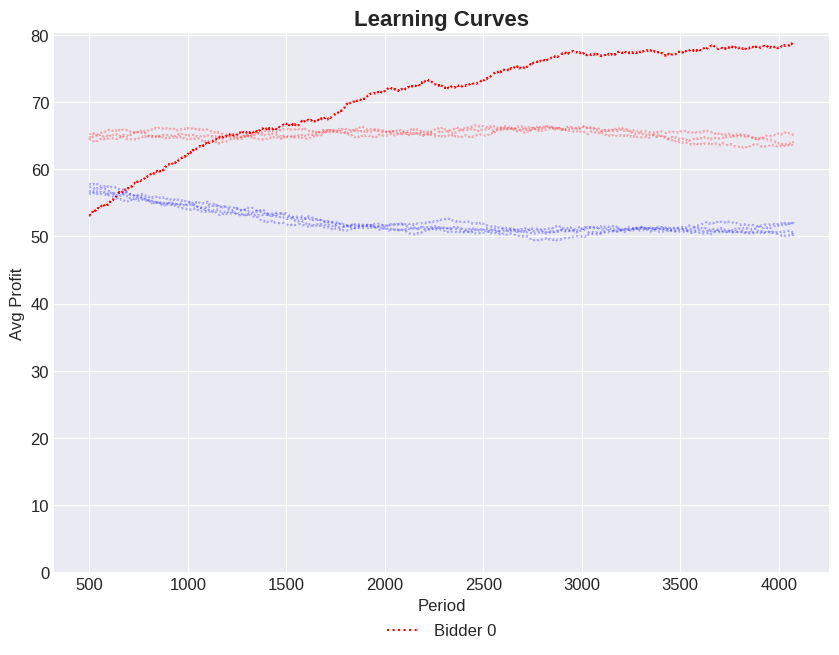

In [5]:
log.findCurrentTraders()
log.graphLearning(rolling_window = 500, trackBuyersIdx=[0], trackSellersIdx=[], type = 'rnd')

In [22]:
pd.set_option('display.max_rows', None)  # To display all rows
pd.set_option('display.max_columns', None)  # To display all columns

log.stepData.iloc[-22:-6][['rnd','period','bids', 'asks','currentBid', 'currentBidIdx','currentAsk','currentAskIdx','price','bprofit','sprofit']]

,rnd,period,bids,asks,currentBid,currentBidIdx,currentAsk,currentAskIdx,price,bprofit,sprofit
65216,4076,0,"[61.33, 65.8, 64.0, 49.0]","[48.8, 42.2, 58.9, 66.5]",65.800000,1,42.2,1,54.000000,35.513556,13.238078
65217,4076,0,"[64.98, 57.4, 42.2, 60.1]","[59.6, 55.7, 60.9, 48.7]",64.981939,0,48.7,3,56.840970,30.536748,10.156169
65218,4076,0,"[59.8, 75.3, 47.9, 64.5]","[44.3, 64.5, 61.5, 54.6]",75.300000,1,44.3,0,59.800000,24.495286,19.944485
65219,4076,0,"[57.73, 59.3, 63.4, 46.2]","[56.8, 68.0, 63.3, 61.5]",63.400000,2,56.8,0,60.100000,22.282710,11.223103
65220,4076,0,"[62.0, 61.8, 39.2, 76.6]","[54.8, 56.7, 47.5, 69.3]",76.600000,3,47.5,2,62.050000,19.726431,17.564575
65221,4076,0,"[62.43, 42.3, 68.0, 50.9]","[53.8, 67.5, 59.9, 68.3]",68.000000,2,53.8,0,60.900000,16.481772,10.412202
65222,4076,0,"[61.91, 51.4, 44.3, 67.0]","[70.4, 52.3, 61.9, 56.2]",67.000000,3,52.3,1,59.650000,19.457580,12.175268
65223,4076,0,"[60.55, 71.6, 41.0, 43.3]","[64.1, 75.5, 69.2, 49.6]",71.600000,1,49.6,3,60.600000,18.072536,12.822333
65224,4076,0,"[60.42, 52.1, 41.7, 69.0]","[55.5, 74.4, 70.3, 51.7]",69.000000,3,51.7,3,60.350000,15.311985,11.892051
65225,4076,0,"[58.45, 73.9, 61.5, 37.3]","[64.3, 57.5, 67.9, 67.3]",73.900000,1,57.5,1,65.700000,12.151717,13.873836


In [21]:
log.findCurrentTraders()

for i in range(4):
    var = 'bids_' + str(i)
    var2 = 'asks_' + str(i)
    log.stepData[var]=log.stepData[var].round(2)
    log.stepData[var2]=log.stepData[var2].round(2)

log.stepData['bids'] = log.stepData[['bids_0', 'bids_1', 'bids_2', 'bids_3']].apply(list, axis=1)
log.stepData['asks'] = log.stepData[['asks_0', 'asks_1', 'asks_2', 'asks_3']].apply(list, axis=1)


IndexError: index 0 is out of bounds for axis 0 with size 0

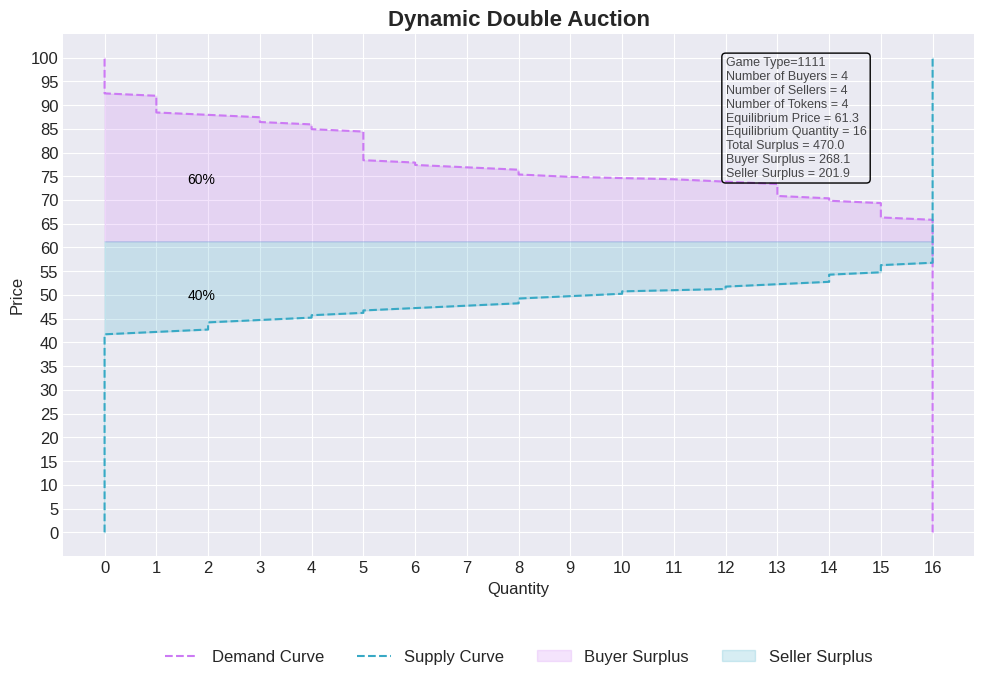

In [19]:
log.graphSales(0, period-1, trackBuyersIdx=[0], trackSellersIdx=[0])

In [15]:

# training loop
for rnd in range(numRounds, 2*numRounds):
    startRounds(gameData, log, buyers, sellers, rnd)
    bprofits, sprofits = 0.0, 0.0
    for period in range(numPeriods, 2*numPeriods):
        startPeriods(buyers, sellers)
        for step in range(numSteps):
            startSteps(buyers, sellers)

            for i in range(numBuyers):
                buyers[i].state = log.generateState(buyers[i], cnt, numStates)

            bids, asks = collectOffers(buyers, sellers)
            currentAsk, currentAskIdx, currentBid, currentBidIdx = bestOffers(bids, asks)
            price, buy, sell = trade(buyers, sellers, currentAsk, currentAskIdx, currentBid, currentBidIdx)
            bprofit, sprofit = 0, 0
            if price > 0:
                buyers[currentBidIdx].transact(price)
                sellers[currentAskIdx].transact(price)
                bprofit = buyers[currentBidIdx].stepProfits
                sprofit = sellers[currentAskIdx].stepProfits
            log.addStep([rnd, period, step, currentBid, currentAsk,  buy, sell, price, price>0,
                         currentBidIdx==0, currentBidIdx==1, currentBidIdx==2, currentBidIdx==3, 
                         currentAskIdx==0, currentAskIdx==1, currentAskIdx==2, currentAskIdx==3, 
                         bids[0], bids[1], bids[2], bids[3], 
                         asks[0], asks[1], asks[2], asks[3], 
                         bprofit, sprofit])
            observe(buyers, sellers, log.disclose())
            endSteps(buyers, sellers)
            
            for i in range(numBuyers):
                buyers[i].newState = log.generateState(buyers[i], cnt, numStates)
                
            if step == numSteps - 1:
                for i in range(numBuyers):
                    buyers[i].done = True                  
            else:
                for i in range(numBuyers):
                    buyers[i].done = False

            agentsObserve(buyers, sellers)
            agentsTrain(buyers, sellers)
            cnt+=1
        endPeriods(buyers, sellers)
    endRounds(buyers, sellers)

# terminate
log.findCurrentTraders()